In [1]:
import requests
import re
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import warnings
warnings.filterwarnings('ignore')

## Get and read in data

In [2]:
city = 'fargo'
state = 'nd'
%run zillow_data_scrape.py fargo nd

Scraping data...
Done.
Fargo_Homes_ForSale.csv is available for viewing.
Fargo_Apartments_ForRental.csv is available for viewing.


In [3]:
df = pd.read_csv("./data/" + city + "_Homes_ForSale.csv")
df2 = pd.read_csv("./data/" + city + "_Apartments_ForRental.csv")

null_price = df[df["unformattedPrice"].isnull()]
null_price2 = df2[df2["unformattedPrice"].isnull()]
df.drop(null_price.index, inplace=True)
df2.drop(null_price2.index, inplace=True)

df.loc[df['zestimate'] == 0, 'zestimate'] = df.loc[df['zestimate'] == 0, 'unformattedPrice']
df.loc[df['zestimate'].isnull(), 'zestimate'] = df['unformattedPrice']
df['best_deal'] = df['zestimate'] - df['unformattedPrice']
df.sort_values("best_deal")

df2.loc[df2['zestimate'] == 0, 'zestimate'] = df2.loc[df2['zestimate'] == 0, 'unformattedPrice']
df2.loc[df2['zestimate'].isnull(), 'zestimate'] = df2['unformattedPrice']
df2['best_deal'] = df2['zestimate'] - df2['unformattedPrice']
df2.sort_values("unformattedPrice")
print("Number of houses for sale in "+city+": "+str(len(df)))
print("Number of apartments for rental in "+city+": "+str(len(df2)))

Number of houses for sale in Fargo: 330
Number of apartments for rental in Fargo: 54


## Homes

#### averages of price and best deal

In [4]:
home_averages = df.copy()

num_cols = home_averages.select_dtypes(include=['int', 'float']).drop(['zpid', 'addressZipcode'], axis=1)

home_averages = pd.DataFrame({
    'mean': num_cols.mean(),
    'median': num_cols.median(),
    'mode': num_cols.mode().iloc[0]
}).transpose()

home_averages = home_averages.round(decimals = 2)
home_averages = home_averages[['unformattedPrice', 'zestimate', 'best_deal', 'beds', 'baths', 'area']]
home_averages = home_averages.tail(3)

names = ['Mean', 'Median', 'Mode']
home_averages['name'] = names
new_col = home_averages['name']
home_averages = home_averages.drop('name', axis=1)
home_averages.insert(0, 'name', new_col)

home_averages = home_averages.rename(columns={'unformattedPrice': 'price'}) 
print('Statistics on the Average House For Sale in '+ city + ':' )
home_averages

Statistics on the Average House For Sale in Fargo:


,name,price,zestimate,best_deal,beds,baths,area
mean,Mean,426567.07,423542.21,-3024.86,3.31,2.57,2352.56
median,Median,379950.00,379950.50,0.00,3.00,3.00,2117.00
mode,Mode,98900.00,98900.00,0.00,4.00,3.00,2040.00


### Histogram of prices

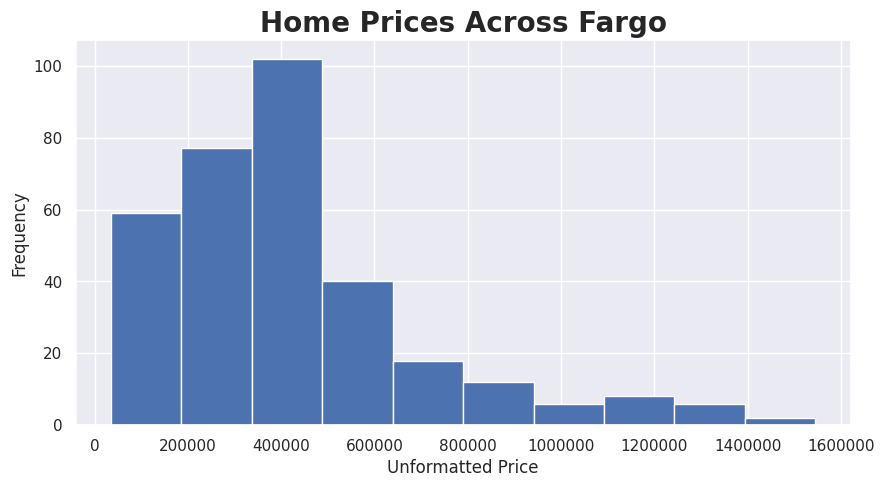

In [5]:
sns.set(rc={"figure.figsize":(10, 5)})
plt.hist(df['unformattedPrice'])
plt.xlabel('Unformatted Price')
plt.ylabel('Frequency')
plt.title('Home Prices Across '+ city, fontdict={'size': 20, 'weight': 'bold'})
plt.ticklabel_format(style='plain', axis="x")
plt.show()

## Pie chart of builders

Note: This chart doesn't include houses where the construction company was unlisted


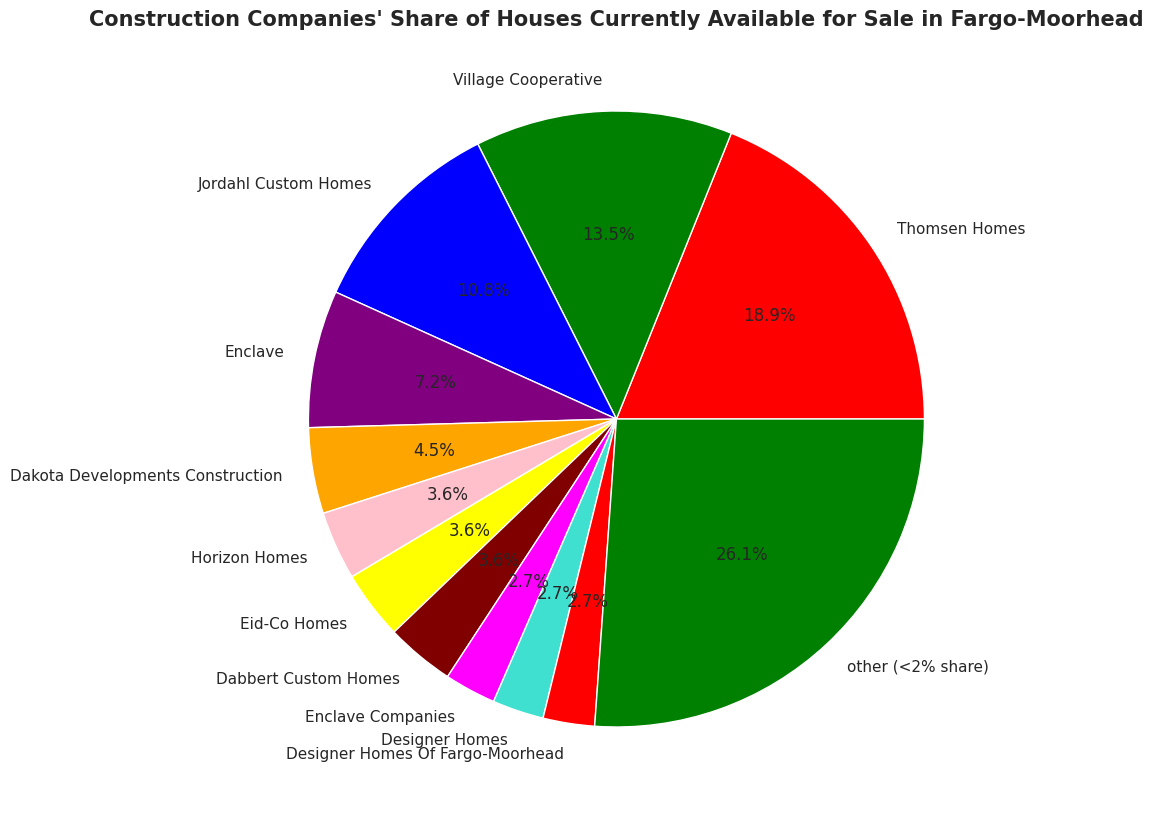

In [6]:
builders = df.copy()

to_replace = [', llc', 'llc', ', inc']
for substring in to_replace:
    builders['builderName'] = builders['builderName'].str.replace(substring, '')

builder_count = builders["builderName"].value_counts()

total = builder_count.sum()
threshold = 0.02

builder_percent = builder_count/builder_count.sum()
other_percent = builder_percent[builder_percent < threshold].sum()
builder_percent = builder_percent[builder_percent >= threshold]
builder_percent["other (<2% share)"] = other_percent

builder_percent.plot.pie(figsize=(15, 10), autopct='%1.1f%%', colors=['red', 'green', 'blue', 'purple', 'orange', 'pink', 'yellow', 'maroon', 'magenta', 'turquoise' ])
plt.title("Construction Companies' Share of Houses Currently Available for Sale in Fargo-Moorhead", fontdict={'size': 15, 'weight': 'bold'})
plt.ylabel("")
print("Note: This chart doesn't include houses where the construction company was unlisted")
plt.show()

## Pie chart of brokers

Note: This chart doesn't include houses where the brokerage was unlisted


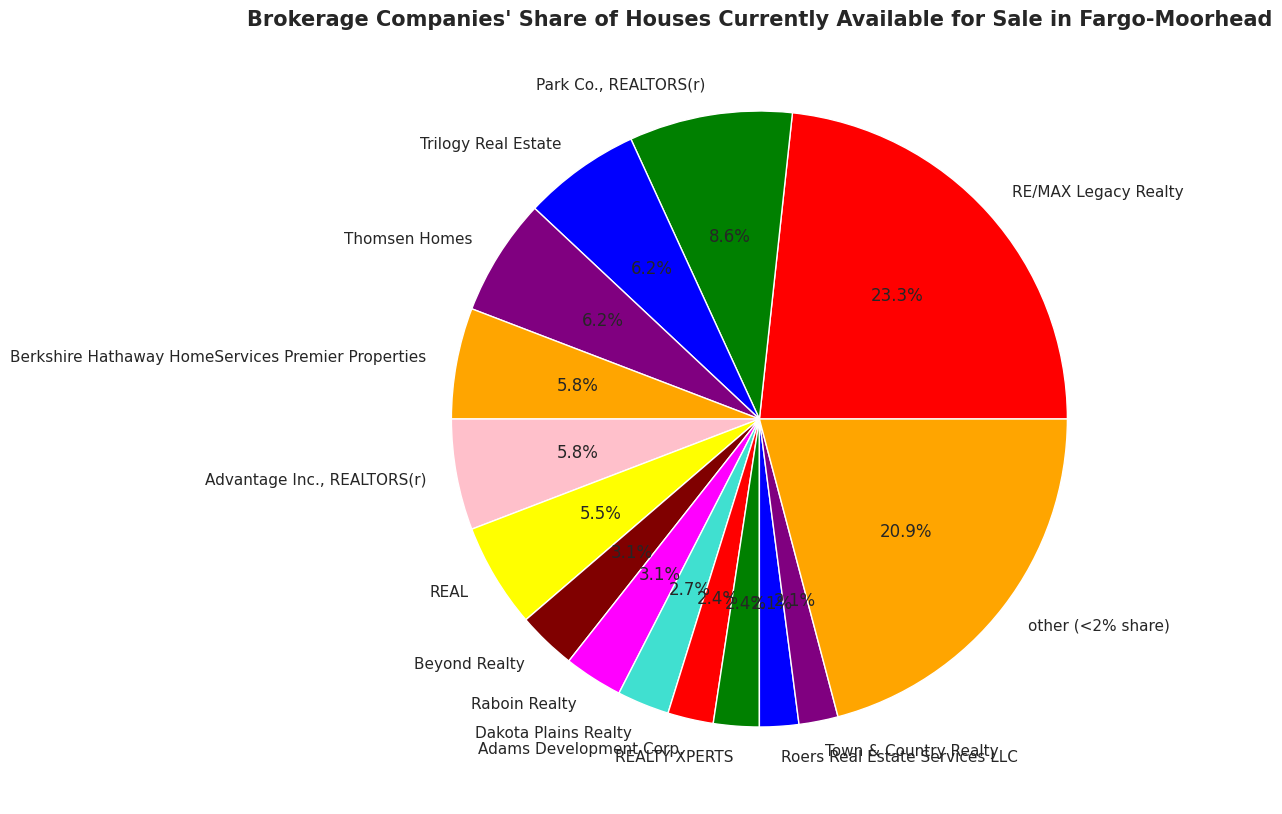

In [7]:
brokers = df.copy()

to_replace = [', llc', 'llc', ', inc']
for substring in to_replace:
    brokers['brokerName'] = brokers['brokerName'].str.replace(substring, '')

broker_count = brokers["brokerName"].value_counts()

total = broker_count.sum()
threshold = 0.02

broker_percent = broker_count/broker_count.sum()
other_percent = broker_percent[broker_percent < threshold].sum()
broker_percent = broker_percent[broker_percent >= threshold]
broker_percent["other (<2% share)"] = other_percent

broker_percent.plot.pie(figsize=(15, 10), autopct='%1.1f%%', colors=['red', 'green', 'blue', 'purple', 'orange', 'pink', 'yellow', 'maroon', 'magenta', 'turquoise' ])
plt.title("Brokerage Companies' Share of Houses Currently Available for Sale in Fargo-Moorhead", fontdict={'size': 15, 'weight': 'bold'})
plt.ylabel("")
print("Note: This chart doesn't include houses where the brokerage was unlisted")
plt.show()

## Beds and Baths

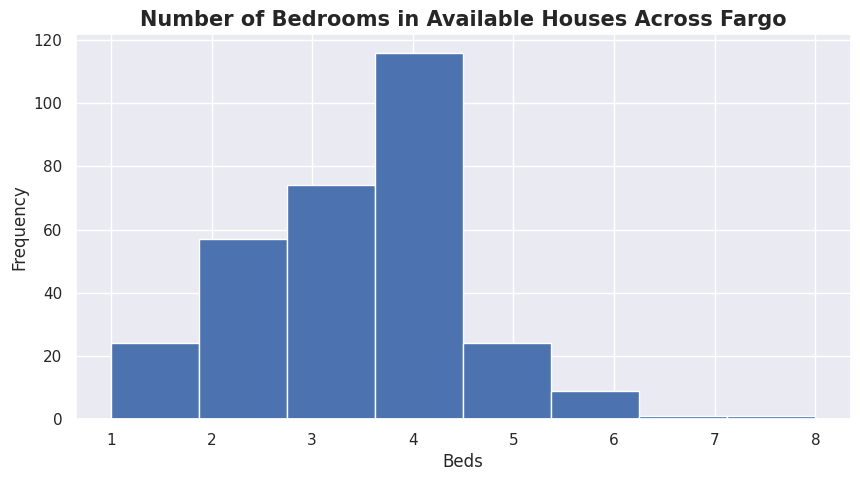

In [8]:
sns.set(rc={"figure.figsize":(10, 5)})
num_beds = int(df['beds'].max())
plt.hist(df['beds'], bins=num_beds)
plt.xlabel('Beds')
plt.ylabel('Frequency')
plt.title('Number of Bedrooms in Available Houses Across '+city, fontdict={'size': 15, 'weight': 'bold'})
plt.show()

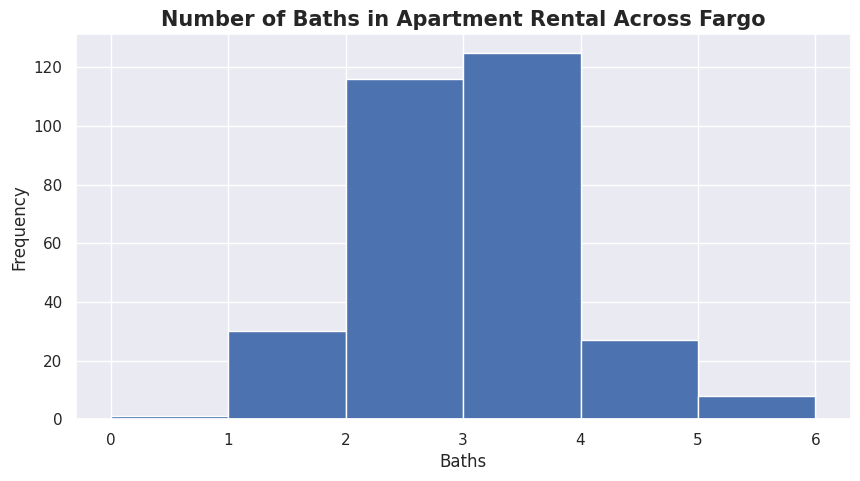

In [9]:
sns.set(rc={"figure.figsize":(10, 5)})
num_bins = int(df['baths'].max())
plt.hist(df['baths'], bins=num_bins, range={df['baths'].min(), df['baths'].max()})
plt.xlabel('Baths')
plt.ylabel('Frequency')
plt.title('Number of Baths in Apartment Rental Across '+ city, fontdict={'size': 15, 'weight': 'bold'})
plt.show()

## Scatter plot comparing Area with Price

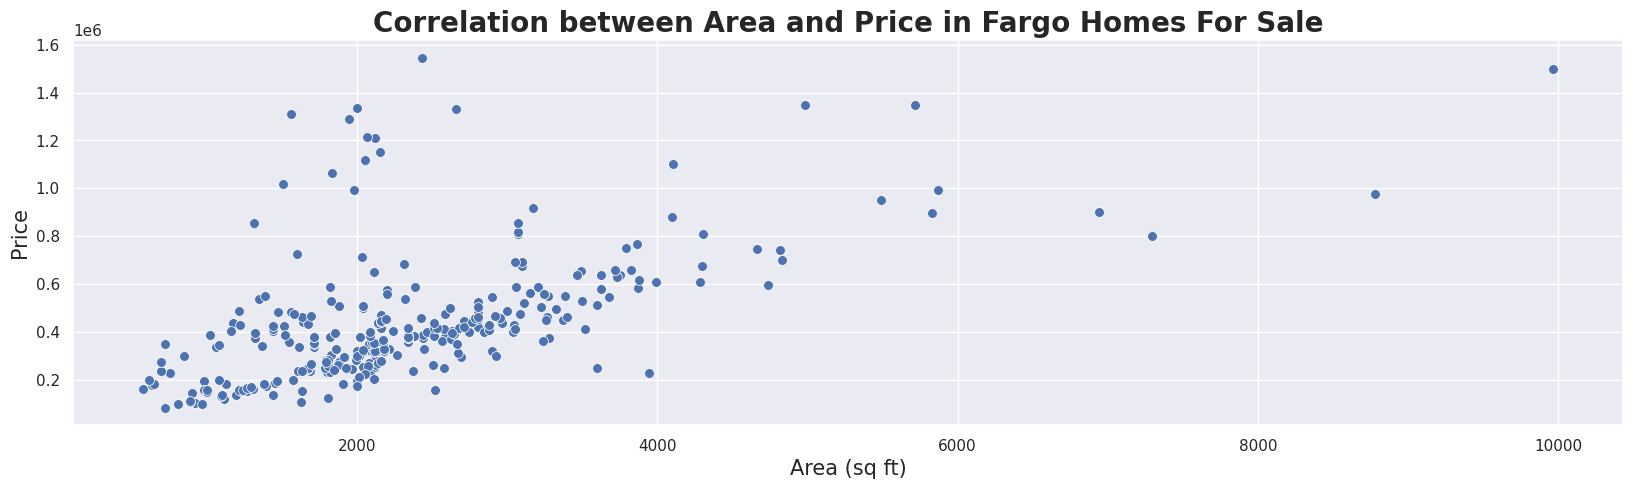

In [10]:
sns.set(rc={"figure.figsize":(20, 5)})
scatter = sns.scatterplot(data=df, x='area', y='unformattedPrice', legend='auto', s=50)
scatter.set_title("Correlation between Area and Price in "+ city + " Homes For Sale", fontdict={'size': 20, 'weight': 'bold'})
scatter.set_xlabel('Area (sq ft)', fontdict={'size': 15})
scatter.set_ylabel('Price', fontdict={'size': 15})
plt.show()

# Apartments

## Averages

In [11]:
apt_averages = df2.copy()

num_cols = apt_averages.select_dtypes(include=['int', 'float']).drop(['addressZipcode'], axis=1)

apt_averages = pd.DataFrame({
    'mean': num_cols.mean(),
    'median': num_cols.median(),
    'mode': num_cols.mode().iloc[0]
}).transpose()

apt_averages = apt_averages.round(decimals = 2)
apt_averages = apt_averages[['unformattedPrice', 'zestimate', 'best_deal', 'beds', 'baths', 'area']]
apt_averages = apt_averages.tail(3)

names = ['Mean', 'Median', 'Mode']
apt_averages['name'] = names
new_col = apt_averages['name']
apt_averages = apt_averages.drop('name', axis=1)
apt_averages.insert(0, 'name', new_col)

apt_averages = apt_averages.rename(columns={'unformattedPrice': 'price'}) 

print('Average Apartment For Rental in '+ city + ': ')
apt_averages

Average Apartment For Rental in Fargo: 


,name,price,zestimate,best_deal,beds,baths,area
mean,Mean,839.72,839.72,0.0,1.7,1.18,992.42
median,Median,750.00,750.00,0.0,2.0,1.00,850.00
mode,Mode,695.00,695.00,0.0,2.0,1.00,800.00


## Histogram of price

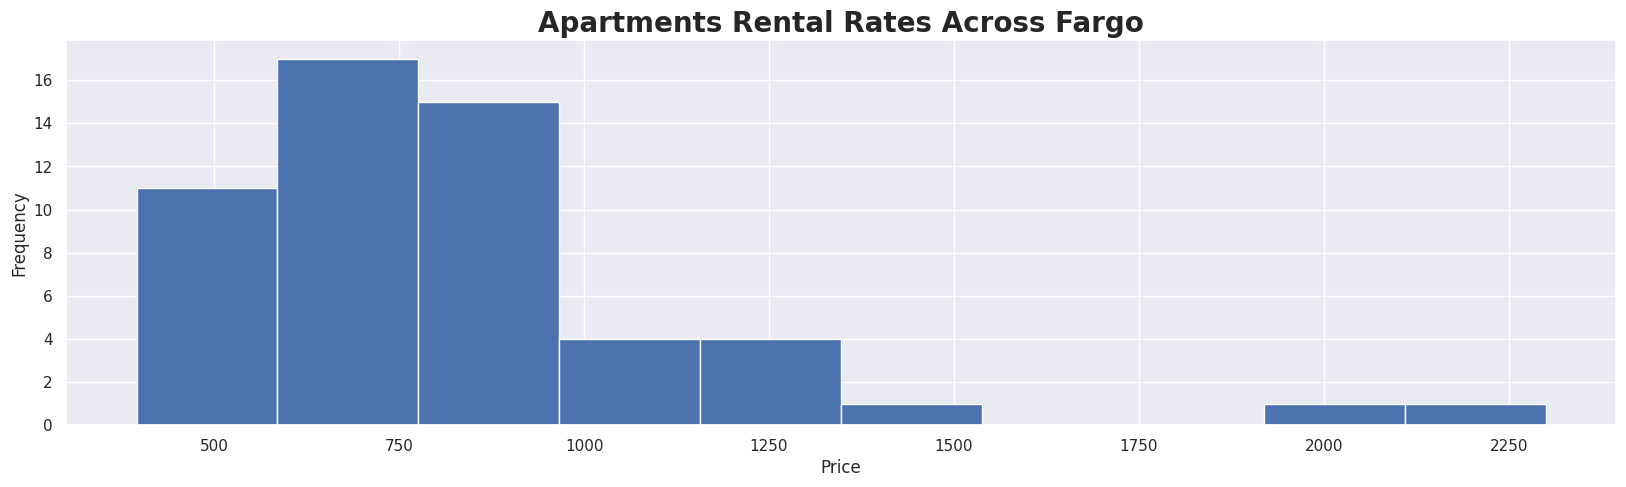

In [12]:
plt.hist(df2['unformattedPrice'])
plt.xlabel('Rate per Month')
plt.ylabel('Frequency')
plt.title('Apartments Rental Rates Across ' + city, fontdict={'size': 20, 'weight': 'bold'})
plt.show()

## Beds, baths, and area

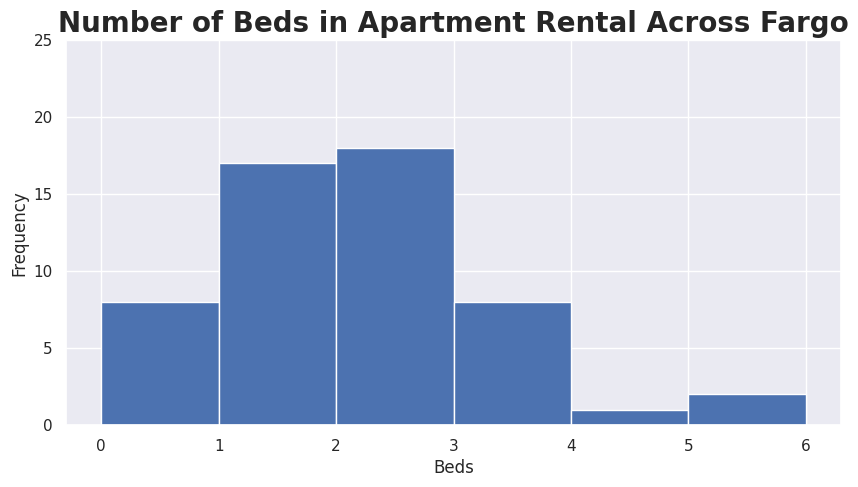

In [13]:
sns.set(rc={"figure.figsize":(10, 5)})
num_bins = int(df2['beds'].max())
plt.hist(df2['beds'], bins=num_bins, range={df2['beds'].max(),df2['beds'].min()})
plt.xlabel('Beds')
plt.ylabel('Frequency')
plt.title('Number of Beds in Apartment Rental Across '+ city, fontdict={'size': 20, 'weight': 'bold'})
plt.ylim(0, 25)
plt.show()

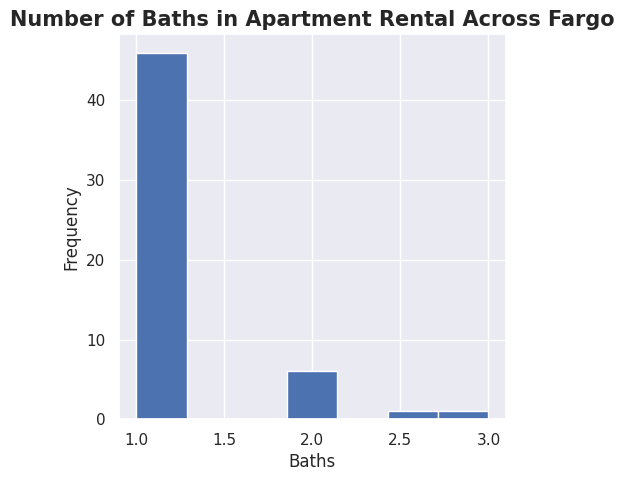

In [14]:
sns.set(rc={"figure.figsize":(5, 5)})
num_beds = int(df2['beds'].max())+1
plt.hist(df2['baths'], bins=num_beds, range={df2['baths'].min(), df2['baths'].max()})
plt.xlabel('Baths')
plt.ylabel('Frequency')
plt.title('Number of Baths in Apartment Rentals Across '+city, fontdict={'size': 15, 'weight': 'bold'})
plt.ticklabel_format(style='plain', axis="x")
plt.show()

## Scatter plot comparing Area with Price

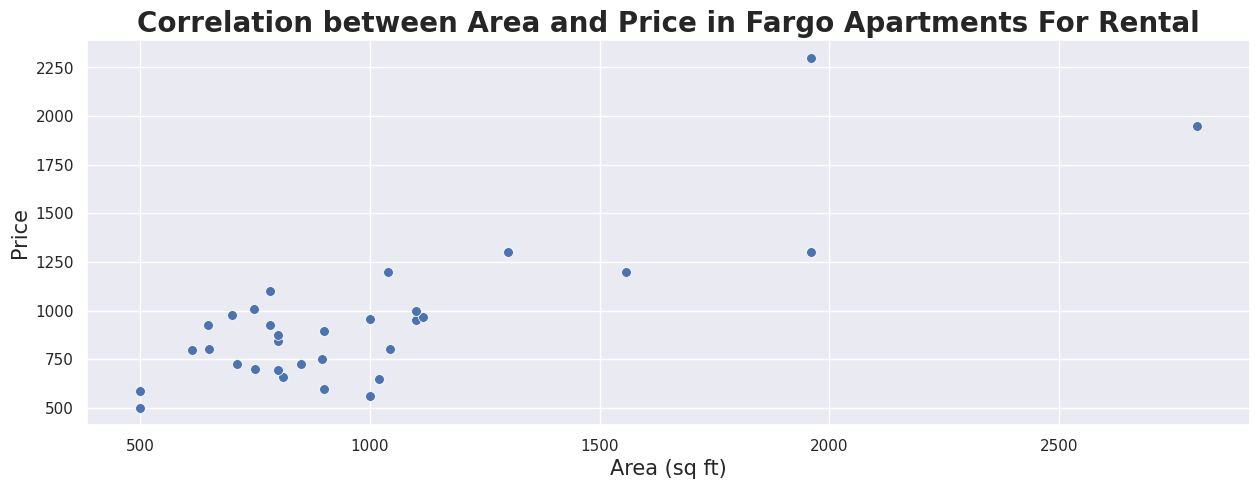

In [15]:
sns.set(rc={"figure.figsize":(15, 5)})
scatter = sns.scatterplot(data=df2, x='area', y='unformattedPrice', legend='auto', s=50)
scatter.set_title("Correlation between Area and Price in "+ city + " Apartments For Rental", fontdict={'size': 20, 'weight': 'bold'})
scatter.set_xlabel('Area (sq ft)', fontdict={'size': 15})
scatter.set_ylabel('Price', fontdict={'size': 15})
plt.show()